# R-STDP

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from random import gauss
from random import randint
from random import random
import scipy.sparse as sparse
import scipy.stats as stats

In [4]:
def neural_network(I_init, gl, Cm, num):
    U_rest = -0.065           
    U_reset = -0.065
    thresh = -0.050                
    tau = Cm/gl
    A_plus = 2                      
    A_neg = -2
    tau_plus = 0.0002
    tau_neg = 0.0002                   
    tau_c = 0.01
    tau_d = 0.002

    T = 0.200                       
    dt = 0.00002                  
    time = np.arange(0, T+dt, dt)       
    
    #Two different time patterns
    tp =[[4,90,90,4,150,10000,10000,10000,10000,10000],[10000,10000,10000,10000,10000,100,15,100,15,15]]

    U_inp = np.zeros((10,len(time)))   
    U_inp[:,0] = U_rest                      
    U_out = np.zeros((2,len(time)),dtype = np.float64) #outer layer
    U_out[:,0] = U_rest
  
    I_init = I_initial(I_init=I_init, time=time,num = num)
    I = np.zeros((10,len(time)))
    I_out = np.zeros((2,len(time)))
    I_out[0,:] = 0.0003
    I_out[1,:] = 0.0003
  
    spikes = [[0] for i in range(10)]          
    spikes_out = [[0],[0]]                     
    mark = np.zeros((10,len(time)))
    mark_out = np.zeros((2,len(time)))
    c1 = np.zeros((10,len(time)))             
    c2 = np.zeros((10,len(time)))
    d1 = np.zeros((10,len(time)))
    d2 = np.zeros((10,len(time)))
    s1 = np.zeros((10,len(time)))
    s2 = np.zeros((10,len(time)))

    STDP_t = [[0],[0]]                         
    s1[:,0] = abs(np.random.normal(3,1,size=(10)))/10  
    s2[:,0] = abs(np.random.normal(4,1,size=(10)))/10
    cnt = 0
    
    for i in range(1,len(time)):
        if(i%500==0): cnt = randint(0,500)%2
        for j in range(10):
            STDP1 , STDP2, DA1, DA2 = 0, 0, 0, 0 
            
            if(i% 500 == 0):  U_inp[j][i-1] = U_rest
            I[j][i]= I[j][i] + I_init[i]*bool(i%500 > tp[cnt][j])
          
            U_inp[j][i] = (((U_rest - U_inp[j][i-1]) + I[j][i]/gl)*dt)/tau + U_inp[j][i-1]
   
            if (U_inp[j][i] > thresh):STDP1, STDP2 = STDP(spikes_out,time[i], tau_neg, STDP_t, A_neg)
            c1[j][i] =(-c1[j][i-1]/tau_c + STDP1)*dt+c1[j][i-1]
            c2[j][i] =(-c2[j][i-1]/tau_c + STDP2)*dt+c2[j][i-1]
           
            if mark[j][i] == 1 : DA1 , DA2 = DA(spikes_out,spikes[j][-1],A_neg)
    
            d1[j][i] = (-d1[j][i-1]/tau_d + DA1)*dt + d1[j][i-1]
            d2[j][i] = (-d2[j][i-1]/tau_d + DA2)*dt + d2[j][i-1]
            
            s1[j][i] = c1[j][i]*d1[j][i]*dt*1000*bool(c1[j][i]*d1[j][i]*0.02+s1[j][i-1]>0) + s1[j][i-1] 
            s2[j][i] = c2[j][i]*d2[j][i]*dt*1000*bool(c2[j][i]*d2[j][i]*0.02+s2[j][i-1]>0) + s2[j][i-1]
                    
            if U_inp[j][i] > thresh :
                U_inp[j][i-1] = 0.04          
                U_inp[j][i] = U_reset        
                spikes[j].append(time[i])     
                mark[j][i+5+j] = 1  
                if(i< 9996):
                    add_amount = I_values(j,i,I_init,time,spikes,s1[j][i],s2[j][i])
                    I_out[:,i+1:i+3] = I_out[:,i+1:i+3] + add_amount
                         
        for l in range(2):
            
            STDP1 , STDP2, DA1, DA2 = 0, 0, 0, 0 
            U_out[l,i] = (((U_rest - U_out[l,i-1]) + I_out[l,i]/gl)*dt)/tau + U_out[l,i-1]
            
            if (mark_out[l][i] == 2):
                
                for j in range(10):
                    DA1 , DA2 = DA(spikes_out,spikes[j][-1],A_plus)
                    if(l==1):d1[j][i] = (-d1[j][i-1]/tau_d + DA1)*dt + d1[j][i]
                    if(l==2):d2[j][i] = (-d2[j][i-1]/tau_d + DA2)*dt + d2[j][i]
                    
                
            if U_out[l][i] > thresh:
                U_out[l][i-1] = 0.04       
                U_out[l][i] = U_reset       
                spikes_out[l].append(time[i])
                mark_out[l][i+7+j] = 2
                for j in range(10):
                    STDP1, STDP2 = STDP(spikes_out,spikes[j][-1], tau_plus, STDP_t, A_plus)
                    if(l==1):
                        c1[j][i]=(-c1[j][i-1]/tau_c+STDP1)*dt+c1[j][i]
                        s1[j][i] = c1[j][i]*d1[j][i]*dt*1000*bool(c1[j][i]*d1[j][i]*0.02+s1[j][i]>0)+s1[j][i]
                        
                    if(l==2):    
                        c2[j][i]=(-c2[j][i-1]/tau_c+STDP2)*dt+c2[j][i]
                        s2[j][i] = c2[j][i]*d2[j][i]*dt*1000*bool(c2[j][i]*d2[j][i]*0.02+s2[j][i]>0)+s2[j][i] 
    return  spikes, U_out, s1, c1, d1 , s2, c2, d2            

In [7]:
def I_initial(I_init=0.005, time=None, num = 1):
    I0 = np.zeros(len(time))
    I0[0:10000] = I_init
    return I0

In [8]:
def I_values(j=0,i=0,I_init = 0.05, time=None, spikes=None, s1=None, s2=None, tau_I=0.001):
    exp1= (time[i+1:i+3] - spikes[j][-1])/tau_I
    exp2= np.exp(1-exp1)
    exp3= exp1*exp2
    W = np.array([s1, s2])
    I_inp = np.dot(W.reshape(2,1),exp3.reshape(1,2))
    return I_inp

In [9]:
def STDP(t_post=None, t_pre=0, tau_t=0.005, STDP_t=None, A = 1, amount1=0, amount2=0):
    if( len(t_post[0]) != 1 ):
        amount1 = A*math.exp(-1*abs(t_post[0][-1] - t_pre)/tau_t)*9000
        STDP_t[0].append(amount1)
    
    if( len(t_post[1]) != 1 ):
        amount2 = A*math.exp(-1*abs(t_post[1][-1] - t_pre))*10000
        STDP_t[1].append(amount2)
    return amount1,amount2

In [10]:
def DA(t_post=None, t_pre=0,A=1,tau_t=0.00005,D1 = 0 ,D2 = 0):
    if(t_post[0][-1] - t_pre < 0 ):
        D1 = A*math.exp(-1*abs(t_post[0][-1] - t_pre))/tau_t*10
        #D1=-100000               
    elif(t_post[0][-1] - t_pre >0 and abs(t_post[0][-1] - t_pre < 0.07)):
        D1 = A*math.exp(-1*abs(t_post[0][-1] - t_pre))/tau_t*10
        #D1=150000
    if(t_post[1][-1] - t_pre < 0 ):                              
        D2 = -A*math.exp(-1*abs(t_post[1][-1] - t_pre))/tau_t*10
        #D2= -100000
    elif(t_post[1][-1] - t_pre >0 and abs(t_post[1][-1] - t_pre < 0.07)):  
        D2 = A*math.exp(-1*abs(t_post[1][-1] - t_pre))/tau_t*10
        #D2= 150000
    return  D1,D2

In [11]:
def simul_STDP(I_init ,gl_init ,Cm_init, num):
    T = 0.200                      
    dt = 0.00002                      
    time = np.arange(0, T+dt, dt)     

    spike, U_out, s1 , c1 , d1 , s2 , c2, d2 = neural_network(I_init, gl_init, Cm_init, num)
    
    for i in range(len(spike)): spike[i].pop(0)
    
    axis_color = 'lightgoldenrodyellow'
    fig = plt.figure("input layer neurons", figsize=(14, 4))
    colors1 = ['C{}'.format(i) for i in range(10)]
    plt.title("spike raster plot")
    plt.eventplot(spike, color=colors1)
    plt.ylabel("Neuron")
    plt.xlabel("Spike - Time [s]")
    
    fig = plt.figure("Potential U for output layer neurons", figsize=(14, 6))
    plt.title("Potential U for output layer neurons")
    plt.plot(time, U_out[0][:], label="Potential:U")[0]
    plt.plot(time, U_out[1][:], label="Potential:U")[0]
    plt.ylabel("Potential [V]")
    plt.xlabel("Time [s]")
    fig = plt.figure("Reinforcement learning", figsize=(16, 16))
    plt.subplot(231)
    plt.title("weight")
    for i in range(10):
        plt.plot(time, s1[i][:], label="Potential:U")[0]
    
    plt.subplot(232)
    plt.title("dopaminergic neurons")
    plt.plot(time, d1[i][:], label="Dopamine")[0]
    
    plt.subplot(233)
    plt.title("eligibility trace")
    plt.plot(time, c1[i][:], label="plasticity")[0]
    
    plt.subplot(234)
    plt.title("weight")
    for i in range(10):
        plt.plot(time, s2[i][:], label="Potential:U")[0]
        print(s1[i][-1],s2[i][-1])
    
    plt.subplot(235)
    plt.title("dopaminergic neurons")
    plt.plot(time, d2[i][:], label="Dopamine")[0]
    
    plt.subplot(236)
    plt.title("eligibility trace")
    plt.plot(time, c2[i][:], label="plasticity")[0]

33.275535840559215 51.5567366796897
0.3564662966806662 3.772354212672003e-11
0.17975807263851198 2.006831989679048e-11
33.40055942169352 51.20867826739984
27.005256304567258 7.96710642109099e-11
0.3782284693024771 1.178315511989107e-12
0.29005020544503435 2.538850782700003e-13
0.2563316945530289 4.8126495862668876e-14
0.3342422803270696 2.2756185037887634e-14
0.1547521648574444 4.10858720024443e-14


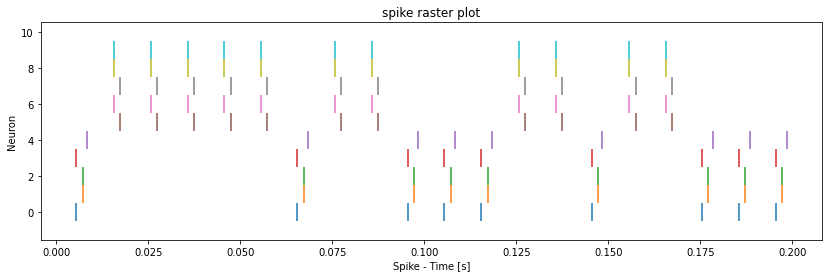

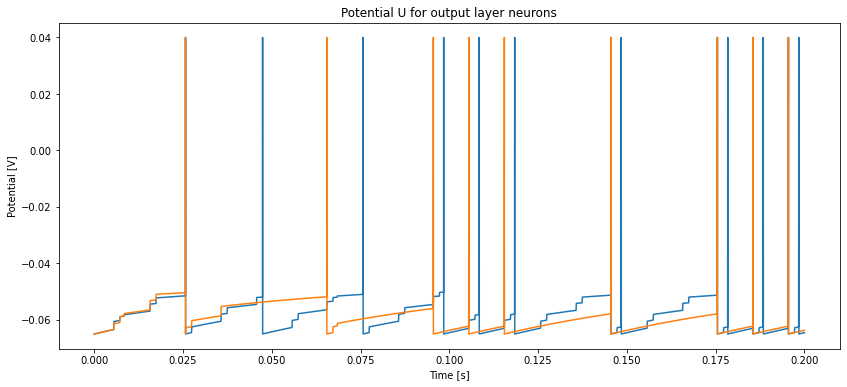

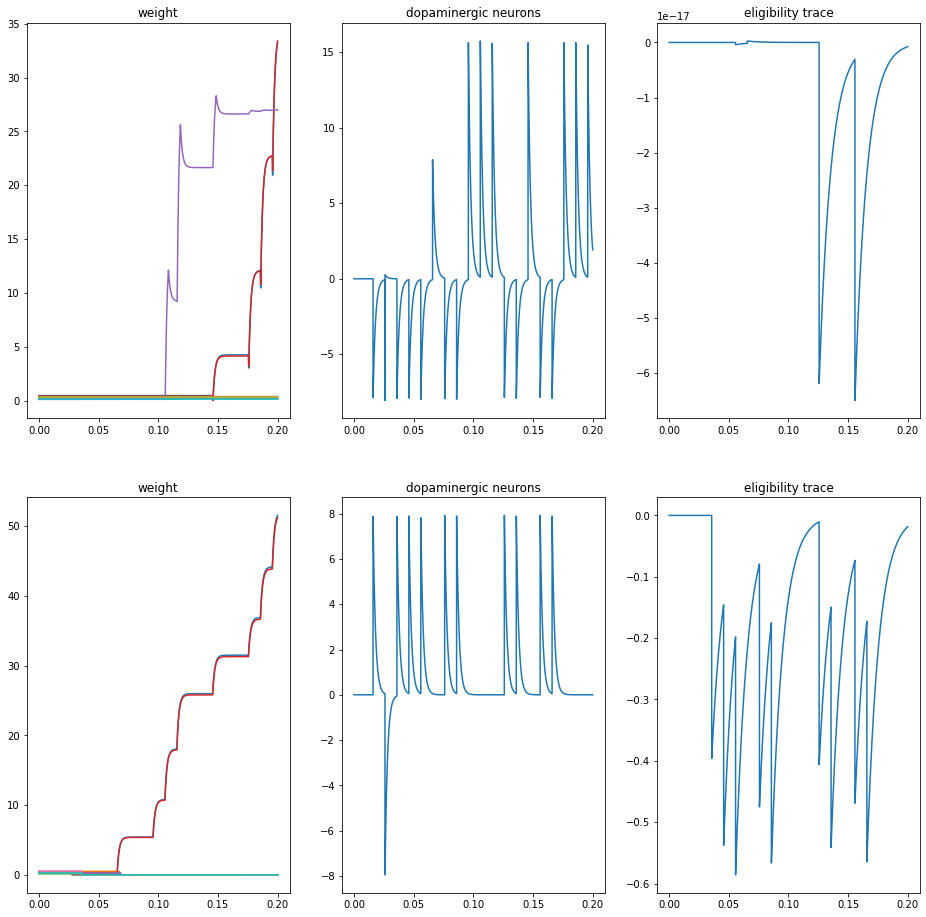

In [12]:
simul_STDP(0.0029 ,0.016,0.001 ,1)